# Cyclistic Dataset Analysis
by Phuc Pham

### Goals
Find the difference in habits of annual members and casual riders to recommend top three recommendations for design marketing to convert casual into annual members

### Data sources used
The analysis is based on Cyclistic’s historical trip data. While the dataset contains data from 2013 uptil now, this analysis only uses 12 months data of 2021 so that it can truly reflect the current business of Cyclistic. The datasetcan be accessed through the link below.

Dataset link: https://divvy-tripdata.s3.amazonaws.com/index.html


In [1]:
#import library
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from math import sin, cos, sqrt, atan2
import glob

In [2]:
# import data from 12 months of Cyclistic
path = r'D:\Saint Louis 4th\Google certificate\Cyclistic\Dataset' # Replace the path with your files destination
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

### Cleaning and data transformation

To ensure the integrity of the data, every null values are subjected to be removed. The Haversine function will be applied to find the distance between the starting point and the ending point of every trip. The duration of every trip will also be calculated to better understand the habits of casual and member customers. Column of month is added to evalute the habits over a timeline. Other methods are applied to transform the previous data into more useful format. 

Outliers are detected in the duration of service usage, thus, interquartile range method is applied to filter out outliers.


In [3]:
#Remove unused columns ('start_station_name')
df.drop(['start_station_name', 'start_station_id','end_station_name','end_station_id'], axis=1, inplace=True)

#Remove null value
df.dropna(inplace=True)


In [4]:
# Create Haversince function to calculate the distance using coordination

def haversine_func(start_lat, start_lng, end_lat, end_lng, to_radians=True, earth_radius=6371):
    """
    credited to stackoverflow answer at: https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows

    """
    if to_radians:
        start_lat, start_lng, end_lat, end_lng = np.radians([start_lat, start_lng, end_lat, end_lng])

    a = np.sin((end_lat-start_lat)/2.0)**2 + \
        np.cos(start_lat) * np.cos(end_lat) * np.sin((end_lng-start_lng)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

# Create function to convert timedelta data into minute
def minutes(td):
    return td / np.timedelta64(1, 'm')

In [5]:
# Add 'distance_km' to calculate distance in km using defined haversine function
df['distance_km'] = haversine_func(df['start_lat'],df['start_lng'],df['end_lat'],df['end_lng'])

# Add 'month' & 'year' column and change the data format
df['started_at'] = df['started_at'].astype('datetime64')
df['ended_at'] = df['ended_at'].astype('datetime64')
df['month'] = df['started_at'].dt.month
df['year'] = df['started_at'].dt.year

# Cacluate 'duration' column and tranform it into minute
df['duration'] = df['ended_at'] - df['started_at']
df['minutes'] = minutes(df['duration'])


transformed_df = df[['ride_id','rideable_type','month','year','started_at','ended_at','member_casual','distance_km','minutes']]


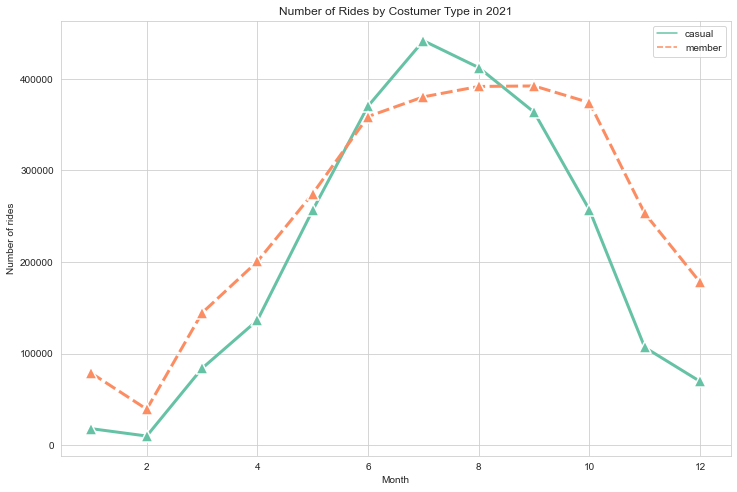

In [6]:
# Create temporary table for graphing
df1 = transformed_df.groupby(['member_casual','month'])['ride_id'].count().reset_index()

# Plot the number of rides by customer type in 2021
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.lineplot(data=df1, x='month',y='ride_id',hue='member_casual', style='member_casual', palette='Set2', linewidth=3, markersize=12, marker="^", markeredgewidth=1.5)
plt.title('Number of Rides by Costumer Type in 2021')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Number of rides')
plt.show()

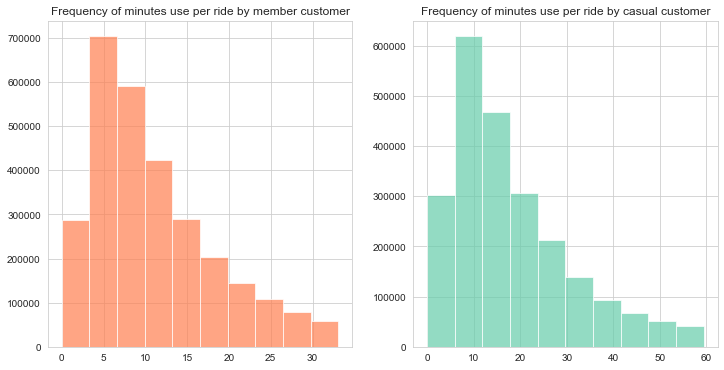

In [7]:
# Split data into member and casual to remove outlier easier
member = df[(df['member_casual'] == 'member') & (df['minutes'] >= 0)]
casual = df[(df['member_casual'] == 'casual') & (df['minutes'] >= 0)]

# calculate interquartile range
m_q25, m_q75 = np.percentile(member['minutes'], 25), np.percentile(member['minutes'], 75)
m_iqr = m_q75 - m_q25

c_q25, c_q75 = np.percentile(casual['minutes'], 25), np.percentile(casual['minutes'], 75)
c_iqr = c_q75 - c_q25

...
# calculate the outlier cutoff
m_cut_off = m_iqr * 1.5
m_lower, m_upper = m_q25 - m_cut_off, m_q75 + m_cut_off

c_cut_off = c_iqr * 1.5
c_lower, c_upper = c_q25 - c_cut_off, c_q75 + c_cut_off

member = member[(member['minutes'] > m_lower) & (member['minutes'] < m_upper)]
casual = casual[(casual['minutes'] > c_lower) & (casual['minutes'] < c_upper)]


member_summary = member.describe()
casual_summary = casual.describe()


df_all = pd.concat([member_summary[['distance_km','minutes']], casual_summary[['distance_km','minutes']]], 
                   axis='columns', keys=['Member Customer', 'Casual Customer'])
df_all = df_all.style.format("{:.4f}")

# Merge casual and member table again for visualization
transformed = pd.concat([member, casual], axis=0, ignore_index=True)

# Plot histogram plots for frequency of minutes use per ride of Cyclistic service
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.hist(transformed[transformed['member_casual'] == 'member']['minutes'], color='coral', alpha=0.7)
plt.title('Frequency of minutes use per ride by member customer')


plt.subplot(1,2,2)
plt.hist(transformed[transformed['member_casual'] == 'casual']['minutes'], color='mediumaquamarine', alpha=0.7)
plt.title('Frequency of minutes use per ride by casual customer')
plt.show()

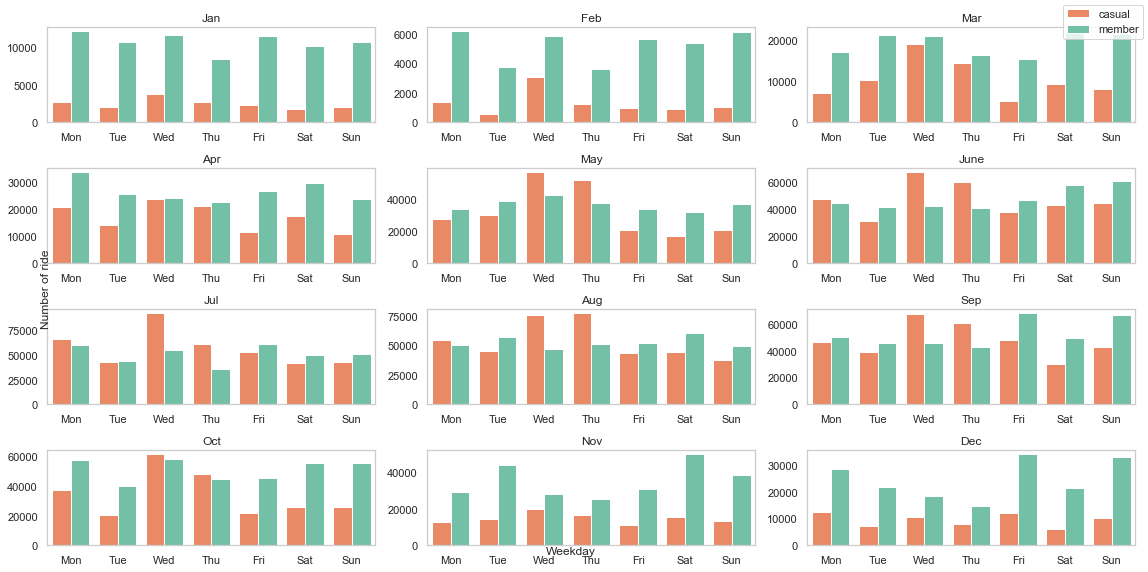

In [243]:
# Add "weekday" column 
transformed['weekday'] = transformed['started_at'].dt.day_name()
week_df = transformed.groupby(['weekday','member_casual','month'])['ride_id'].count().reset_index(name='number_of_ride')
week_df['weekday'] = week_df['weekday'].str[:3]

# Create month table 
month_df = week_df[['weekday','member_casual','month','number_of_ride']].set_index('month')

# Loop through every month to plot frequency of ride by week day 
month = ['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct','Nov','Dec']
label = ['M','T','W','Th']

fig, axes = plt.subplots(4, 3, sharex=True, figsize=(16,8))

for i in range(0,12):
    x = pd.DataFrame(month_df.loc[i+1])
    ax = plt.subplot(4,3,i+1)
    sns.barplot(ax=ax,x='weekday', y='number_of_ride', hue='member_casual', data=x, palette=['mediumaquamarine','coral'])
    bars = ('Mon','Tue','Wed','Thu','Fri','Sat','Sun')
    x_pos = np.arange(len(bars))
    ax.get_legend().remove()
    ax.set(ylabel=None, xlabel=None)
    ax.grid(False)
    plt.title(month[i])
    plt.xticks(x_pos, bars)



# set the common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=1)
# set x and y label for the graph
fig.tight_layout(pad=1.0)
fig.text(0.5, 0.04, 'Weekday', ha='center')
fig.text(0.04, 0.5, 'Number of ride', va='center', rotation='vertical')
plt.show()


### Findings

* November to February recognize a drop in number of ride probably due to the cold weather. However, the number of ride by member customer is maintained and much higher than casual member.

* Throughout the year, the member customer use the service more than casual member. However, during summer period, casual rider use a little bit more than member customer.

* While in general causal riders use the service less often than the member, casual riders' average length of use (18 minutes) is longer than member riders'(10.9 minutes) and the average distance between starting and ending of the trip is recognized to be longer in casual driver than member riders.

* For most member customers, the duration per trip is often between 5-10 minutes while it is often double (10-20 minutes) for casual customers

* Member customer's usage of Cyclistic shows consistency throughout the weekdays, especially high during Saturday while Wednesday and Thursday recognize a surge in the use of Cyclistic for casual customer.

### Recommendations

* Lauch a survey for customers after every trip to find out the purpose of their trip to understand the need of them so that Cyclistic can segment a target group of casual member and design a member package to satisfy that need. 
    * Ex: a customer who use Cyclistic for periodically workout might interesting in a sport package where if the total miles she travel higher than the predetermined target, she will get rewards and discount. Such package will only encourage the user to use Cyclistic services more. 
 

* Focus on marketing campaign in the summer, especially June, July and August - the 3 months with highest number of ride.

* Run advertisement on Cyclistic application more frequent for casual user on Wednesday, Thursday since those days record highest frequency of service use among casual rider.
    ** Ex: A pop-up message like "Are you going out again? Cyclistic has a good deal for you, upgrade your membership status 
    with just ... dollars" or "Ride the same cost less" on every time they start.

* More data should be acquired to better understand the habits of the customer, especially the customer data: age, gender, location. The better understanding of customers' needs the better approach Cyclistic can approach to convert casual into member customer

* Besides the potential reduction in cost, Cyclistic should find another benefit for casual member to join in membership.
    ** Discount for complementary goods (things that associated with cycling like helmet, shoes,..) or rewards after travel certain miles per month.
    

